## Demo PyHeat Youri & Mathis

Ceci est une notebook de démo pour la lib pyheat.
C'est une version temporaire

Toutes les valeurs utilisées dans ce notebook sont totalement arbitraires.
L'objectif n'est pas de montrer des résultats mais le fonctionnement de la lib et ses entrées/sorties.

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime

In [2]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")


In [3]:
capteur_riviere = pd.read_csv("data/processed_pressures_pt2022-2.csv", names = ['dates', 'dH', 'temperature_riviere'], skiprows=1, index_col=0)
capteur_ZH = pd.read_csv("data/processed_temperatures_pt2022-2.csv", names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
convertDates(capteur_riviere)
convertDates(capteur_ZH)

# set seed for reproducibility
np.random.seed(0)

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + 273.15
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + 273.15
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + 273.15
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + 273.15
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + 273.15

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

In [4]:
# démo de définition de l'objet colonne avec de vraies mesures
col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4],
	"offset": .05,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None, #float
    "sigma_meas_T": None, #float
}

col = Column.from_dict(col_dict)

In [5]:
# vérification que checker renvoie une erreur si on demande des infos avant d'avoir activé la méthode solve
try:
    col.get_depths_solve()
except ComputationOrderException as e:
    print(e)
    
try:
    col.get_all_n()
except ComputationOrderException as e:
    print(e)

compute_solve_transi has to be computed before calling get_depths_solve.
compute_mcmc has to be computed before calling get_all_n.


In [6]:
# check Peut définir un tuple avec la class Param (NamedTuple)
params = Param(
    moinslog10K = 4,
    n = .1,
    lambda_s = 2,
    rhos_cs = 4e6
)

#Ou en tuple plus classiquement
params_tuple = (4, .1, 2, 4e6)

assert params == params_tuple

In [7]:
col.compute_solve_transi(params, 100)

temps = col.temps_solve

col.compute_solve_transi(params_tuple, 100)

temps_from_tuple = col.temps_solve

#assert np.array_equal(temps, temps_from_tuple)
assert np.allclose(temps, temps_from_tuple, equal_nan=True) #array_equal bon ssi les arrays contiennent des integers, np.allclose si float

--- Compute Solve Transi ---
One layer : moinslog10K = 4, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Done.
--- Compute Solve Transi ---
One layer : moinslog10K = 4, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Done.


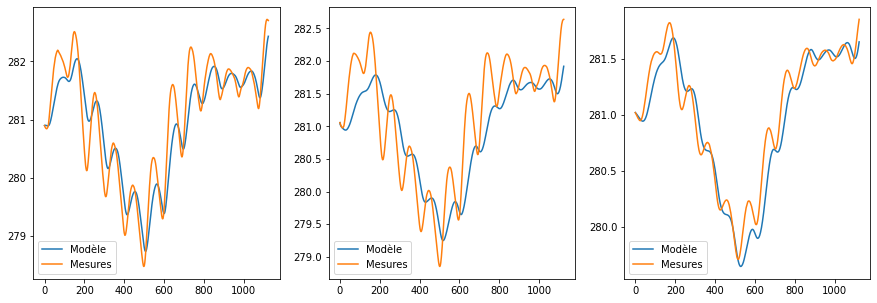

In [8]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

for i, id in enumerate(col.get_id_sensors()):
    axes[i].plot(col.get_temps_solve()[id,::], label="Modèle")
    axes[i].plot(col._T_measures[::,i], label="Mesures")

    axes[i].legend()

277.6099

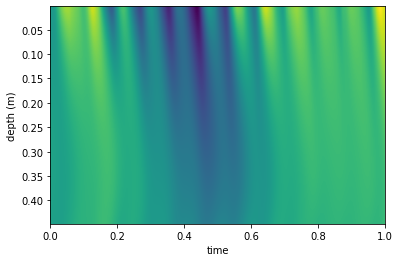

In [9]:
#Tout est stocké dans la class col pour ne pas avoir à le stocker hors de la class
fig, ax = plt.subplots(facecolor = 'w')

ax.imshow(
    col.temps_solve,
    aspect = "auto",
    extent = [0, 1, col.depths_solve[-1], col.depths_solve[0]], #TODO : trouver comment monter le datetime
)

ax.set_xlabel("time")
ax.set_ylabel("depth (m)")
np.nanmin(col.temps_solve[:,:-5])

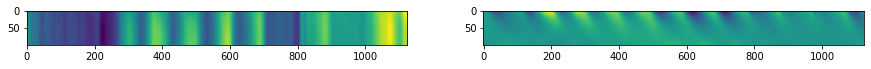

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,8), facecolor = 'w')
axs[0].imshow(col.advec_flows_solve)
#axs[1].imshow(col.advec_flows_solve)
axs[1].imshow(col.conduc_flows_solve)

Text(0, 0.5, 'temperature (K)')

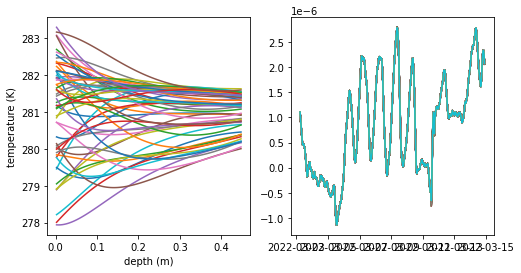

In [11]:
from itertools import islice

fig, axs = plt.subplots(1, 2, figsize=(8,4),facecolor = 'w')

ite = zip(
    col.temps_solve.T,
    col.times_solve
)
for temps, t in islice(ite, 20, None, 20):
    axs[0].plot(
        col.depths_solve,
        temps,
        label = f"{t:.1e}"
    )
axs[1].plot(
    col.times_solve,
    col.flows_solve.T,
    label = f"{t:.1e}"
)

axs[0].set_xlabel("depth (m)")
axs[0].set_ylabel("temperature (K)")
#axs[1].legend()

Index 23 in z_array -> 0.10575000000000001
Temp at index 23 and t = 0 -> 281.415
Temp at 0.106 -> 280.847
col.get_temps correct inaccuracy in z.
Temp at 0.107 -> 280.847


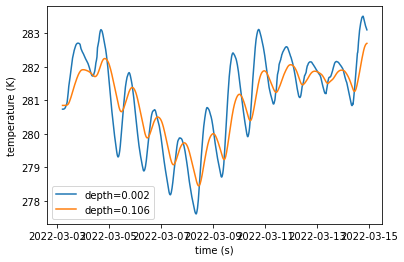

In [12]:
ind = 23
print(f"Index {ind} in z_array -> {col.depths_solve[ind]}")
print(f"Temp at index {ind} and t = 0 -> {col.temps_solve[0, ind]:.3f}")
print(f"Temp at {col.depths_solve[ind]:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind])[0]:.3f}")
print("col.get_temps correct inaccuracy in z.")
print(f"Temp at {col.depths_solve[ind]+1e-3:.3f} -> {col.get_temps_solve(z = col.depths_solve[ind]+1e-4)[0]:.3f}")

fig, ax = plt.subplots(facecolor = 'w')
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[0]), label = f"depth={col.depths_solve[0]:.3f}")
ax.plot(col.times_solve, col.get_temps_solve(col.depths_solve[ind]), label = f"depth={col.depths_solve[ind]:.3f}")
ax.set_xlabel("time (s)")
ax.set_ylabel("temperature (K)")
ax.legend()
#TODO : Faire la meme avec le temps en paramètre

In [13]:
priors = {
    "moinslog10K": ((1.5, 6), .01), # (intervalle, sigma)
    "n": ((.01, .25), .01),
    "lambda_s": ((1, 5), .1),
    "rhos_cs": ((1e6,1e7), 1e5)
}

PARAM_LIST = (
    "moinslog10K",
    "n",
    "lambda_s",
    "rhos_cs"
)

all_priors = [['couche1', 0.2,
            [Prior(*args) for args in (priors[lbl]
                                       for lbl in PARAM_LIST)]],
            ['couche2', 0.45,
            [Prior(*args) for args in (priors[lbl]
                                       for lbl in PARAM_LIST)]
        ]
        ]

sigma_prior = Prior((0.1, np.inf), 0.02, lambda x : 1/x)

col.compute_mcmc(
    nb_iter = 200,
    all_priors = all_priors,
    nb_cells = 100,
    quantile = (.05, .5, .95),
    sigma2_temp_prior = sigma_prior,
)

--- Compute Mcmc ---
Priors :
    [Prior sur une valeure qui évolue entre 1.5 et 6, Prior sur une valeure qui évolue entre 0.01 et 0.25, Prior sur une valeure qui évolue entre 1 et 5, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
    [Prior sur une valeure qui évolue entre 1.5 et 6, Prior sur une valeure qui évolue entre 0.01 et 0.25, Prior sur une valeure qui évolue entre 1 et 5, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0]
Number of cells : 100
Number of iterations : 200
Launch Mcmc
Mcmc Computation :   7%|▋         | 14/200 [00:00<00:02, 65.73it/s]

/Users/antoine/Documents/Mines/Cours/2A/Molonari/Projet/pyheatmy2022/pyheatmy/core.py:549: RuntimeWarning: divide by zero encountered in log
  return 0.5 * norm2 / sigma2 + np.size(self._T_measures)*np.log(sigma2)/2 - np.log(sigma2_distrib(sigma2))


Mcmc Computation : 100%|██████████| 200/200 [00:03<00:00, 66.31it/s]
Quantiles Done.


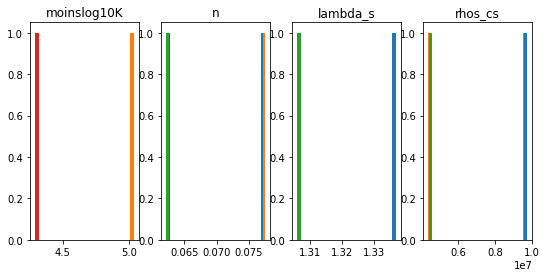

In [14]:
#print("Normal si les resultats ont pas de sens")

fig, axes = plt.subplots(1, 4, figsize = (9,4), facecolor = 'w')

ite = zip(
    ["moinslog10K", "n", "lambda_s", "rhos_cs"],
    [col.all_moinslog10K, col.all_n, col.all_lambda_s, col.all_rhos_cs] 
)

for (lbl, vals), ax in zip(ite, axes):
    ax.hist(vals, bins = 20)
    ax.set_title(lbl)
#col.get_all_n() et ses dérivés sont aussi dispo sous forme de méthodes

Text(0, 0.5, 'acceptance')

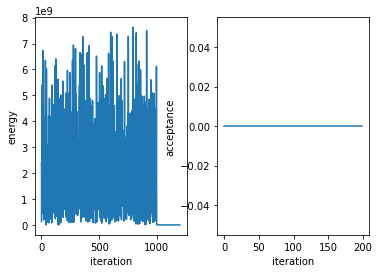

In [15]:
fig, axs = plt.subplots(1,2,facecolor = 'w')
axs[0].plot(col.all_energy)
axs[1].plot(col.all_acceptance_ratio)

axs[0].set_xlabel("iteration")
axs[0].set_ylabel("energy")
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("acceptance")

In [16]:
#Can also sample param from mcmc trajectory
sampled_params = col.get_best_param()
print(sampled_params)

col.compute_solve_transi(sampled_params, 41)

fig, ax = plt.subplots(facecolor = 'w')

ax.imshow(
    col.temps_solve,
    aspect = "auto",
    extent = [col.depths_solve[0], col.depths_solve[-1], 0, 1]
)

ax.set_xlabel("depth (m)")
ax.set_ylabel("time (s)")

[Parametres(moinslog10K=5.044505517226702, n=0.062103429034789145, lambda_s=1.3371300756270128, rhos_cs=9778364.479350034), Parametres(moinslog10K=4.287687000932541, n=0.07758183311089996, lambda_s=1.3058957213989402, rhos_cs=4351174.899572578)]


AttributeError: 'Parametres' object has no attribute 'zLow'

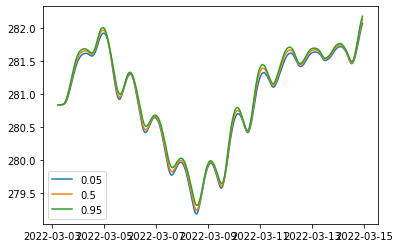

In [17]:
fig, ax = plt.subplots(facecolor = 'w')

#Pas encore possible de donner le temps encore.
for quant in (.05,.5,.95):
    ax.plot(
        col.times_mcmc,
        col.get_temps_quantile(quant)[20, :],
        label = quant
    )
    
ax.legend()